### Read raw data

In [2]:
import pandas as pd
import logging
from statistics import mean
import os

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from numpy import array
from numpy import hstack

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from seaborn import lineplot

logger = logging.getLogger('recession_predictor')
logger.setLevel(logging.DEBUG)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Using TensorFlow backend.
/home/elawad/anaconda3/envs/keras_sandbox/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/elawad/anaconda3/envs/keras_sandbox/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/elawad/anaconda3/envs/keras_sandbox/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [3]:
### READ DATA INTO ONE DATAFRAME

data = pd.concat([pd.read_csv('data/TB3SMFFM.csv', index_col='DATE'),
                  pd.read_csv('data/T1YFFM.csv', index_col='DATE'),
                  pd.read_csv('data/T5YFFM.csv', index_col='DATE'),
                  pd.read_csv('data/T10YFFM.csv', index_col='DATE'),
                  pd.read_csv('data/USREC.csv', index_col='DATE')
                 ], axis=1)
data.index = pd.to_datetime(data.index)

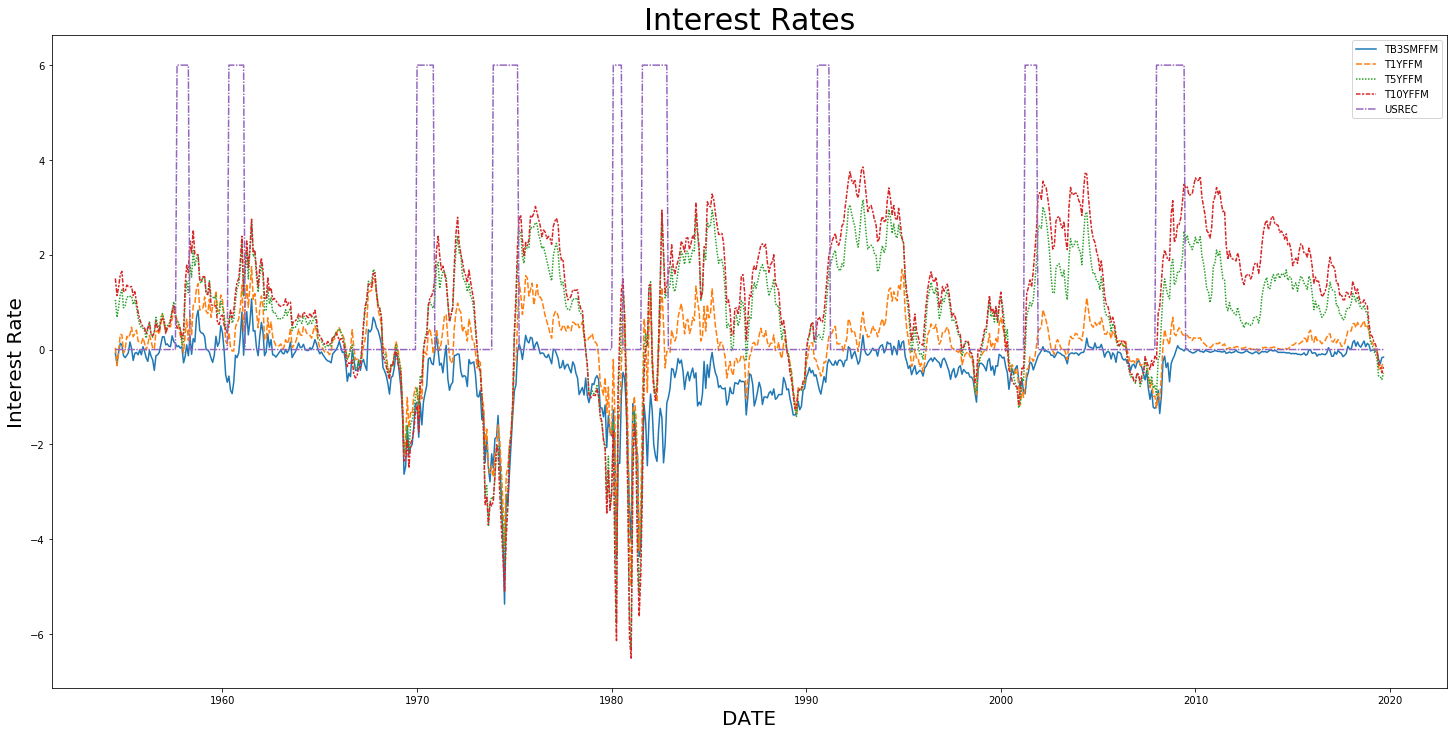

In [4]:
graph = data.copy(deep=True)
graph['USREC'] = graph['USREC'] * 6
fig, ax = plt.subplots(figsize=(25,12)) 
ax.set_title('Interest Rates', size= 30)
plt.xlabel('Date', size=20)
plt.ylabel('Interest Rate', size=20)
ax = lineplot(hue="event",
                   units="subject", estimator=None,
                   data=graph)

### Shift 12 months, create 6 month buckets

In [19]:
remaining_life = []
rm = 0
for i, e in enumerate(reversed(data['USREC'].tolist())):
    if e == 1:
        remaining_life.append(0)
        rm = 0
    if e == 0:
        rm = rm + 1
        remaining_life.append(rm)

remaining_life.reverse()
        
data['remaining_life'] = remaining_life
data

,TB3SMFFM,T1YFFM,T5YFFM,T10YFFM,USREC,remaining_life
DATE,,,,,,
1954-07-01,-0.08,0.04,1.05,1.50,0,38
1954-08-01,-0.30,-0.34,0.68,1.14,0,37
1954-09-01,-0.05,-0.03,0.90,1.32,0,36
1954-10-01,0.13,0.32,1.17,1.58,0,35
1954-11-01,0.10,0.31,1.26,1.65,0,34
...,...,...,...,...,...,...
2019-05-01,-0.04,-0.05,-0.20,0.01,0,5
2019-06-01,-0.21,-0.38,-0.56,-0.31,0,4
2019-07-01,-0.30,-0.44,-0.57,-0.34,0,3


In [20]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def scale(X):
    # Scale features
    scaler = MinMaxScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X)
    return scaled_features, scaler

def graph_results(index, predictions, scaled_target):
    fig, ax = plt.subplots(figsize=(25,12)) 
    #myFmt = mdates.DateFormatter("%y-%m")
    #ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax.set_title('Preds', size= 30)
#    wide_df = data[['preds', target_col]]
    wide_df = pd.DataFrame(index=index)
    wide_df['predictions'] = predictions
    wide_df['target'] = scaled_target
    ax = lineplot(data=wide_df)
    plt.xlabel('Year', size=20)
    plt.ylabel('# of future months in recession', size=20)
    plt.xticks(rotation=45)
    plt.grid(which='major');

In [21]:
dataset = data.reset_index()[['TB3SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'remaining_life']].to_numpy()
time_index = data.reset_index()[['DATE']].to_numpy()

In [22]:
def load_data(dataset, n_steps):
    X, y = split_sequences(dataset, n_steps)
    X = X[:-19]
    y = y[:-19]
    return X, y
    
def create_model(nodes, activation, timesteps, n_features, dropout, optimizer, loss):
    model = Sequential()
    model.add(LSTM(nodes, activation=activation, input_shape=(timesteps, n_features), dropout=dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    
    return model
    
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs):
  
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    
    pred = model.predict(X_test)
    
    return mean_squared_error(y_test, pred)
    
#fit_cross_val(train, test, 10, 'relu', .1, 'adam', 'mse' 200)

def cross_val(np_data, timesteps, n_folds, nodes, activation, dropout, optimizer, loss, epochs):
    scores = []
    X, y = load_data(np_data, timesteps)
    skf = KFold(n_splits=n_folds, random_state=None, shuffle=False)

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print ("Running Fold", i+1, "/", n_folds, end='')
        model = None # Clearing the NN.
        model = create_model(nodes, activation, timesteps, 4, dropout, optimizer, loss)
        score = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index], epochs)
        scores.append(score)
        print(f", score = {score}")
        
    return mean(scores)





In [23]:
cross_val(np_data=dataset,
          timesteps=6,
          n_folds=3,
          nodes=10,
          activation='relu',
          dropout=0,
          optimizer='adam',
          loss='mse', 
          epochs=5)


Running Fold 1 / 3WARNING:tensorflow:From /home/elawad/anaconda3/envs/keras_sandbox/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


, score = 1498.0947790824148
Running Fold 2 / 3, score = 3123.934258939569
Running Fold 3 / 3, score = 2975.5415507521834


2532.523529591389

In [10]:
results = {}

In [11]:
results

{}

In [13]:
for nodes in [100]:
    for timesteps in [2,3]:
        for dropout in [.1,.2,.3]:
            results[(nodes, timesteps, dropout)] = cross_val(np_data=dataset,
                                                             timesteps=timesteps,
                                                             n_folds=3,
                                                             nodes=nodes,
                                                             activation='relu',
                                                             dropout=dropout,
                                                             optimizer='adam',
                                                             loss='mse', 
                                                             epochs=200)

Running Fold 1 / 3, score = 4.16669084686186
Running Fold 2 / 3, score = 4.313159923725717
Running Fold 3 / 3, score = 1.6925824511728658
Running Fold 1 / 3, score = 3.929346219667914
Running Fold 2 / 3, score = 3.4308613295545136
Running Fold 3 / 3, score = 1.7321287968361299
Running Fold 1 / 3, score = 3.902244081520514
Running Fold 2 / 3, score = 2.811076974612161
Running Fold 3 / 3, score = 1.78276536900273
Running Fold 1 / 3, score = 3.988922824644742
Running Fold 2 / 3, score = 6.36698600797475
Running Fold 3 / 3, score = 1.6204154462186848
Running Fold 1 / 3, score = 4.098082566977674
Running Fold 2 / 3, score = 7.250025891850425
Running Fold 3 / 3, score = 1.7098584702360504
Running Fold 1 / 3, score = 4.195797418180932
Running Fold 2 / 3, score = 5.491114876878559
Running Fold 3 / 3, score = 1.6659731580461354


In [17]:
min(results, key=results.get)


(100, 2, 0.3)

In [48]:
# choose a number of time steps
n_steps = 24
# convert into input/output
X, y = split_sequences(dataset, n_steps)
time_steps_crop = time_index[n_steps-1:]
X_train = X[:-19]
y_train = y[:-19]
ts_train = time_steps_crop[0:514]
X_test = X[514:]
y_test = y[514:]
ts_test = time_steps_crop[514:]
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

model = create_model(nodes=100, activation='relu', timesteps=n_steps, n_features=4, dropout=.5, optimizer='adam', loss='mse')

In [49]:
model.fit(X_train, y_train, epochs=200, verbose=0)

In [50]:
pred_t = model.predict(X)


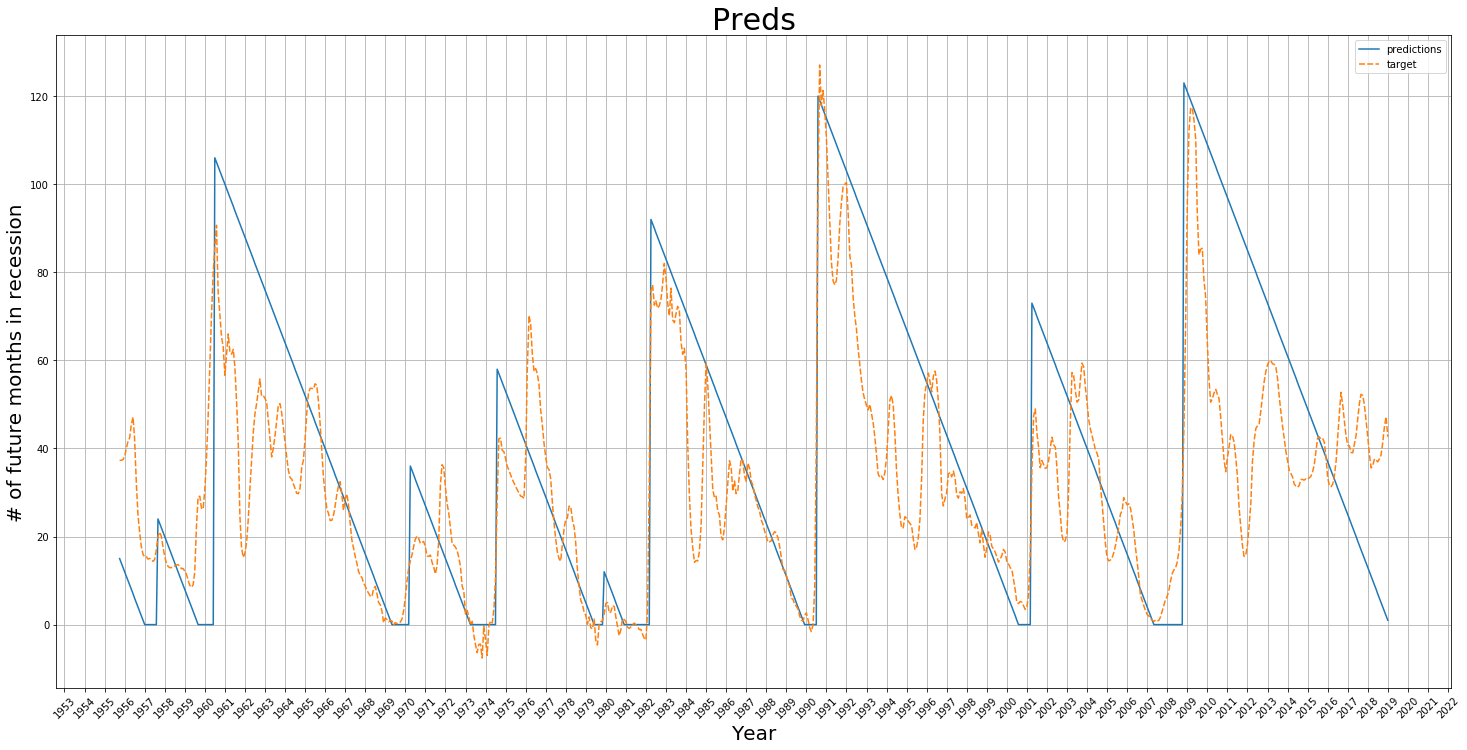

In [51]:
graph_results(hstack(time_steps_crop), y, pred_t)